## **Conversion from conservative to primitive variables in one spatial dimension for the RC-EOS [[Ryu et al. (2006)](https://dx.doi.org/10.1086/505937)]**

#### **Section 1: Packages and backends**
One can use the plotlyjs() backend for an interactive plot. However gr() backend is used here for the output to be compatible with the github preview window.

In [ ]:
using StaticArrays
using Printf
using Plots
# plotlyjs() # For an interactive plot
gr()

Plots.GRBackend()

#### **Section 2: New method of conversion**
Here the method of conversion from conservative to primitive variables proposed in [[Basak et al. (2025)](https://doi.org/10.48550/arXiv.2505.05128)] is discussed.

#### **Section 2.1: Functions used for the conversion**
The root of the function $S(\Pi)$
\begin{align}
S(\Pi) = \Pi^2 - \Pi E - D^2 h  T(h)
\end{align}
with
$$
    T(h) = \frac{3h-8}{24} + \frac{\sqrt{(3h+8)^2-96}}{24}, \qquad h = \frac{\sqrt{\Pi^2 - |m_1|^2}}{D}
$$
needs to be computed by an iterative method for the conversion (Section 2.2 in [[Basak et al. (2025)](https://doi.org/10.48550/arXiv.2505.05128)]). The derivative $S'(\Pi)$  is given by
$$
    S'(\Pi) = \left(2 - \frac{T(h)}{h}-T'(h)\right)\Pi - E
$$
which will be used in the iterative method.

In [2]:
@inline @inbounds function S_and_dS(x::Float64, u::AbstractArray)
   m=abs(u[2])
   D=u[1]
   E=u[3]
   a = sqrt(x^2 - m^2)
   h = a/D
   dhdx = x/(a*D)
   b = sqrt((3*h + 8)^2 - 96)
   T = h/8 - 1/3 + b / 24
   dTdh = 1/8 + 3*(3*h + 8)/(24*b)

   # The required function and its derivative
   S = x^2 - x * E - D^2 * h * T
   dSdx = 2 * x - E - D^2 * dhdx * (T + h * dTdh)
   return S, dSdx
end

S_and_dS (generic function with 1 method)

#### **Section 2.2: Iterative method and primitive variables**
Here, the Newton-Raphson method
$$
    \Pi_{r+1} = \Pi_r - \frac{S(\Pi_r)}{S'(\Pi_r)}, \qquad r = 0,1,2,\ldots
$$
with initial condition $\Pi_0 = E$ is used for for finding the root of the function in equation (1) and the corresponding expressions of primitive variables as in [[Basak et al. (2025)](https://doi.org/10.48550/arXiv.2505.05128)] is given by
$$
    p = \Pi - E,\qquad
    v_1 = \frac{m_1}{\Pi},\qquad
    \rho = D \sqrt{1-|v_1|^2}
$$
where $\Pi$ is the approximation with the above Newton-Raphson method.

In [3]:
@inbounds function con2prim_rc_new(u::AbstractArray)
    D, m1, E = u[1], u[2], u[3]

    x = E # Setting the initial condition
    i = 0 # A counter for the iterartion method
    S, dS = S_and_dS(x, u) # Initial function value and its derivative

    # Set parameters for the convergence of the NR method
    max_iter, tol, reldx = 30, 1.0e-13, 1.0
    
    # Begin iteration of NR method
    while abs(S) > tol && i <= max_iter && reldx > tol
        dx = -S/dS
        reldx = abs(dx/x)
        x += dx
        @assert x > E "The NR method volates Pi > E"
        i += 1
        S, dS =  S_and_dS(x, u)
        # @show x
    end

    # Check if the NR method converged with the desired tolerance
    @assert abs(S) < tol || reldx < tol "The NR method did not converge" 

    # Plotting the function S(Pi) and S'(Pi)
    xx = LinRange(E, x, 1000)
    yy = zeros(length(xx))
    dyy = zeros(length(xx))
    for i=1:length(xx)
        yy[i],dyy[i] = S_and_dS(xx[i],u)
    end
    p_title = plot(title = "Plot of S(Pi) and S'(Pi)", grid = false, showaxis = false, bottom_margin = 0Plots.px, titlefont = font(10));
    plt1 = plot(xx, yy, xlabel="Pi", label="S(Pi)", linecolor = :red, linewidth = 2, xguidefont = font(8))
    scatter!(plt1, [x], [S], label="Final approximated root in NR")
    plt2 = plot(xx, dyy, xlabel="Pi", label="S'(Pi)", linecolor = :blue, linewidth = 2, xguidefont = font(8))
    my_layout = @layout[ a{0.00001h}; b c]
    plt = plot(p_title, plt1, plt2, layout=my_layout, size=(800, 400))
    display(plt)

    # Primitive variables
    v1 = m1 / x
    p = x - E
    LF = 1 / sqrt(1 - v1^2)
    rho = D / LF
    return SVector(rho,v1,p)
end

con2prim_rc_new (generic function with 1 method)

#### **Section 3: Old method of conversion**
Here the method of conversion from conservative to primitive variables proposed in [[Ryu et al. (2006)](https://dx.doi.org/10.1086/505937)] is discussed.

#### **Section 3.1: Functions used for the conversion**
Here two functions are used for the conversion. Firstly, the function in equation (29) in [[Ryu et al. (2006)](https://dx.doi.org/10.1086/505937)], given by
\begin{align}
    f(\Gamma) = \sqrt{\Gamma^2 - 1} f_1(\Gamma) - f_2(\Gamma) \tag{2}
\end{align}
is considered and secondly, a simplified form
\begin{align}
    g(\Gamma) = (\Gamma^2 - 1) f_1^2(\Gamma) - f_2^2(\Gamma) \tag{3}
\end{align}
by squaring both sides of equation (29) in [[Ryu et al. (2006)](https://dx.doi.org/10.1086/505937)] is considered. Here,
\begin{align*}
    f_1(\Gamma) &= |m_1| \left[3 E \Gamma \left(8 \Gamma^2 - 1\right) + 2D \left(1 - 4 \Gamma^2\right)\right],\\ 
    f_2(\Gamma) &= 3 \Gamma^2 \left[4\left(|m_1|^2 + E^2\right)\Gamma^2 - \left(|m_1|^2 + 4 E^2\right)\right] - 2 D \left(4 E \Gamma - D\right) \left(\Gamma^2 - 1\right)
\end{align*}
The corresponding derivatives are
\begin{align*}
    f'(\Gamma) &= \frac{\Gamma}{\sqrt{\Gamma^2 - 1}} f_1(\Gamma) + \sqrt{\Gamma^2 - 1} f_1'(\Gamma) - f_2'(\Gamma) \\
    g'(\Gamma) &= 2 \Gamma f_1^2(\Gamma) + 2 f_1(\Gamma) (\Gamma^2 - 1) f_1'(\Gamma) - 2 f_2(\Gamma) f_2'(\Gamma)
\end{align*}
with
\begin{align*}
    f_1'(\Gamma) &= |m_1| \left[3 E (8 \Gamma^2 - 1) -16 D \Gamma + 48 E \Gamma^2 \right], \\
    \qquad f_2'(\Gamma) &= 48 \Gamma^3 (E^2 + |m_1|^2) - 4 D \Gamma (4 E \Gamma - D) - 8 D E (\Gamma^2 - 1) - 6 \Gamma \left[4 E^2 + |m_1|^2\right]
\end{align*}
An iterative method needs to be used to find the root of the polynomials in equations (2) and (3) which are required for the conversion. Below is a Julia code snippet for the function $f(\Gamma)$ and $g(\Gamma)$ along with their derivatives.


In [4]:
# Some functions along with their derivatives, that are required for the derivative of the original function
@inline function f1f2_df1df2(x::Float64, u::SVector)
    D = u[1]
    m = abs(u[2])
    E = u[3]

    f_1 = m * (3 * E * x * (8 * x^2 - 1) + 2 * D * (1 - 4 * x^2))
    f_2 = 3 * x^2 * (4 * (m^2 + E^2) * x^2 - (m^2 + 4 * E^2)) - 2 * D * (4 * E * x - D) * (x^2 - 1)

    # Derivatives of f_1 and f_2
    df_1 = m * (3 * E * (8 * x^2 - 1) - 16 * D * x + 48 * E * x^2)
    df_2 = 48 * x^3 * (E^2 + m^2) - 4 * D * x * (4 * E * x - D) - 8 * D * E * (x^2 - 1) - 6 * x * (4 * E^2 + m^2)

    return f_1, f_2, df_1, df_2
end

# f(x) and f'(x) (Before squaring)
@inline function f_and_df_Ryu(x::Float64, u::SVector)
    f_1, f_2, df_1, df_2 = f1f2_df1df2(x, u)
    f   = sqrt(x^2 - 1) * f_1 - f_2
    df = 2 * x/(2 * sqrt(x^2 - 1)) * f_1 + sqrt(x^2 - 1) * df_1 - df_2
    return f, df
end

# g(x) and g'(x) (After squaring)
@inline function g_and_dg_Ryu(x::Float64, u::SVector)
    f_1, f_2, df_1, df_2 = f1f2_df1df2(x, u)
    f   = (x^2 - 1) *f_1^2 - f_2^2
    df = 2 * x * f_1^2 + (x^2 - 1) * 2 * f_1 * df_1 - 2 * f_2 * df_2
    return f, df
end

g_and_dg_Ryu (generic function with 1 method)

####  **Section 3.2: Iterative method and primitive variables**
Here the Newton-Raphson method
$$
    \Gamma_{r+1} = \Gamma_r - \frac{f(\Gamma_r)}{f'(\Gamma_r)}, \qquad r = 0,1,2,\ldots
$$
with initial condition $\Gamma_0 = 1 + 1e-13$ and
$$
    \Gamma_{r+1} = \Gamma_r - \frac{g(\Gamma_r)}{g'(\Gamma_r)}, \qquad r = 0,1,2,\ldots
$$
with initial condition $\Gamma_0 = 1$ are used for finding the root of the function in equations (2) and (3) respectively. Note that, in the first case the initial guess is taken as $1+1e-13$, since taking $1$ will blow up the method, because of having $\sqrt{\Gamma^2 - 1}$ in the denominator of $f'(\Gamma)$.

In [5]:
@inline function newton_raphson(u::SVector, G_0::Float64, G_u::Float64, fn_dfn, s::Int64)
    x = G_0 # Setting the initial condition
    i = 0 # A counter for the iterartion method

    if s ==1 # Case whe using f(LF) (before squaring)
        if x < 1.0 # Case when f'(LF) becomes undefined
            println("The NR method using the function f(LF) fails because of having negative Lorentz factor LF = ", x,  " at initial stage")
            return x, f, 0
        end
    end
    fn, dfn = fn_dfn(x, u) # Initial function value and its derivative

    # Set parameters for the convergence of the NR method
    max_iter, tol, reldx = 100, 1.0e-13, 1.0
    
    # Begin iteration of NR method
    while abs(fn) > tol && i < max_iter && reldx > tol
        dx = -fn/dfn
        reldx = abs(dx/x)
        x_old = x
        x += dx
        i += 1
        if s ==1 # Case when using f(LF)
            if x < 1.0 # Case when f'(LF) becomes undefined
                println("The NR method using the function f(LF) fails because of having negative Lorentz factor LF = ", x,  " at iteration n = ", i, ". At iteration n = ", i-1, ", LF = ", x_old, " and f(LF) = ", fn)
                return x_old, fn, 0
            end
        end
        fn, dfn =  fn_dfn(x, u)
    end
    
    # Check the successful convergence of the NR method
    ss = 1 # A counter which stays 1, if the method converges successfully otherwise becomes 0
    if s == 1 # Case when using f(LF) (before squaring)
        if abs(fn) > tol && reldx > tol # Check if the NR method converged with the desired tolerance
            println("The NR method using the function f(LF) did not converge with Lorentz factor LF_n = ", x, ", f(LF_n) = ", fn,  " at iteration n = ", i)
            ss = 0
        elseif x < 1.0 || x > G_u # Check if the resulted value is within admissible range
            println("The resulted Lorentz factor LF = ", x, " is out of the admissible interval: [1.0, ", G_u, "] for the case of f(LF)")
            ss = 0
        end
    elseif s == 2 # Case when using g(LF) (after squaring)
        if abs(fn) > tol && reldx > tol # Check if the NR method converged with the desired tolerance
            println("The NR method using the function g(LF) did not converge with Lorentz factor LF_n = ", x, ", g(LF_n) = ", fn,  " at iteration n = ", i)
            ss = 0
        elseif x < 1.0 || x > G_u  # Check if the resulted value is within admissible range
            println("The resulted Lorentz factor LF = ", x, " is out of the bounds for the case of g(LF)")
            ss = 0
        end
    end
    return x, fn, ss
end


newton_raphson (generic function with 1 method)

After the successfull iterations of the Newton-Raphson method, the corresponding expressions of primitive variables are found as ([[Ryu et al. (2006)](https://dx.doi.org/10.1086/505937)])
$$
    \rho = \frac{D}{\Gamma},\qquad |v_1| = \frac{\sqrt{\Gamma^2 - 1}}{\Gamma}, \qquad v_1 = \frac{m_1}{|m_1|}|v_1|, \qquad p = \frac{(E-m_1 v_1) - 2\rho + \sqrt{(E - m_1 v_1)^2 + 4 \rho (E - m_1 v_1) - 4 \rho ^2}}{6}
$$
where $\Gamma$ is the approximation with the Newton-Raphson method.

In [6]:
# Primitive variables
@inline function primitives(u:: SVector, root:: Float64)
    D, m1, E = u[1], u[2], u[3]
    abv = (sqrt(root^2 - 1)/root)
    rho = D/root
    v = abv * m1/abs(m1)
    Emv = E - m1*v
    p = (Emv - 2 * rho +  sqrt(Emv^2 + 4*rho * Emv - 4 * rho^2))/6
    return rho, v, p
end

# Calling the NR method for each case and plottings of the functions
function con2prim_rc_Ryu(u:: SVector)
    D, m1, E = u[1], u[2], u[3]

    G1_0 = 1.0 + 1e-13 # Setting the initial condition for the case of f(LF)
    G2_0 = 1.0 # Setting the initial condition for the case of g(LF)

    # Upper bound of Gamma
    G_u = 1/sqrt(1 - m1^2/E^2)

    # Calling the NR functions for both the cases (1 and 2 are used for the cases with f(LF) and g(LF) respectively)
    root1, f1, ss1 = newton_raphson(u, G1_0, G_u, f_and_df_Ryu, 1)
    root2, f2, ss2 = newton_raphson(u, G2_0, G_u, g_and_dg_Ryu, 2)

    # Plotting the function f(x) along with its derivative
    a = 1 # Since f(x) not defined for x < 1 in real field
    b = max(root1, G_u)
    xx = LinRange(a, b, 1000)
    yy = zeros(length(xx))
    dyy = zeros(length(xx))
    for i=1:length(xx)
        yy[i],dyy[i] = f_and_df_Ryu(xx[i],u)
    end
    
    p_title = plot(title = "Plot of function f(LF) and its derivative", grid = false, showaxis = false, bottom_margin = 0Plots.px, titlefont = font(10));
    plt1 = plot(xx, yy, xlabel="LF", label="f(LF)", linecolor = :red, linewidth = 2, xguidefont = font(8))
    scatter!(plt1, [root1], [f1], label="Last approximated root in NR")
    plt2 = plot(xx, dyy, xlabel="LF", label="f'(LF)", linecolor = :blue, linewidth = 2, xguidefont = font(8))
    my_layout = @layout[ a{0.00001h}; b c]
    plt = plot(p_title, plt1, plt2, layout=my_layout, size=(800, 400))
    display(plt)

    # Plotting the function g(x) along with its derivative
    a = min(1, root2); b = max(root2, G_u)
    xx = LinRange(a, b, 1000)
    yy = zeros(length(xx))
    dyy = zeros(length(xx))
    for i=1:length(xx)
        yy[i],dyy[i] = g_and_dg_Ryu(xx[i],u)
    end
    
    p_title = plot(title = "Plot of function g(LF) and its derivative", grid = false, showaxis = false, bottom_margin = 0Plots.px, titlefont = font(10));
    plt1 = plot(xx, yy, xlabel="LF", label="g(LF)", linecolor = :red, linewidth = 2, xguidefont = font(8))
    scatter!(plt1, [root2], [f2], label="Last approximated root in NR")
    plt2 = plot(xx, dyy, xlabel="LF", label="g'(LF)", linecolor = :blue, linewidth = 2, xguidefont = font(8))
    my_layout = @layout[ a{0.00001h}; b c]
    plt = plot(p_title, plt1, plt2, layout=my_layout, size=(800, 400))
    display(plt)
        
    # Primitive variables
    if ss1 == 1 # Case for the successfull convergence of NR methods for the case of f(LF)
        prim1 = primitives(u, root1)
    else
        prim1 = nothing
    end
    if ss2 == 1 # Case for the successfull convergence of NR methods for the case of g(LF)
        prim2 = primitives(u, root2)
    else
        prim2 = nothing
    end
    return prim1, prim2
end

con2prim_rc_Ryu (generic function with 1 method)

#### **Section 4: Conservative variables**
Here, the vector of conservative variables $\mathbf{u} = (D, m_1, E)$ needs to be specified in the below code snippet. Below are some examples when the old method fails but the new method succeeds, supporting the advantage of the new method of conversion. Moreover, there are some examples, for which both the methods converges.

In [7]:
## Examples where the new method succeed but have some problems with old method
u = SVector(0.1, 50.0, 50.01); # Both cases fail in old method
# u = SVector(0.01, 250.0, 250.1); # Both cases fail in old method
# u = SVector(0.26215012530349685, 42.10522585617847, 42.10705317285818); # Both cases fail in old method
# u = SVector(0.001, 25.0, 25.001); # Both cases fail in old method

# u = SVector(1.0, 5.0, 5.1); # The case of g(LF) fails in old method
# u = SVector(3.1238113100313827, 10.192492374215055, 13.347441622342116) # The case of g(LF) fails in old method


## Examples where both methods are working fine
# u = SVector(1.0, 2.0, 5.0);
# u = SVector(1.0, 5.0, 50.0);                                        

#### **Section 5: Conversion from conservative to primitive**
Here, the above user-defined functions are called to find the primitive variables $(\rho, v_1, p)$. The functions in equation (1), (2), and (3) with the approximated roots and the corresponding derivatives are also plotted for a visualisation purpose.

The conservative variables: [0.1, 50.0, 50.01]

The new method of conversion


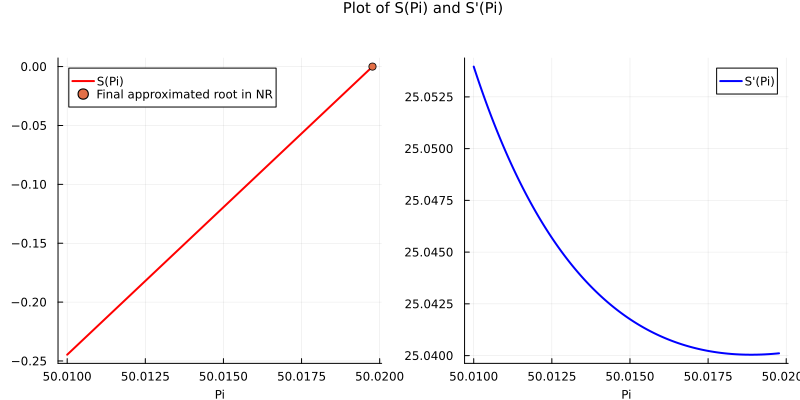

The converted primitive variables: [0.0028112721434486723, 0.9996047593391835, 0.009769846888175948]
The corresponding Lorentz factor LF = 35.57108486741059

The Ryu's method of conversion
The resulted Lorentz factor LF = 53.15173670172856 is out of the admissible interval: [1.0, 50.00749968752995] for the case of f(LF)
The NR method using the function g(LF) did not converge with Lorentz factor LF_n = 0.001407120795317682, g(LF_n) = -0.3099426310311607 at iteration n = 100


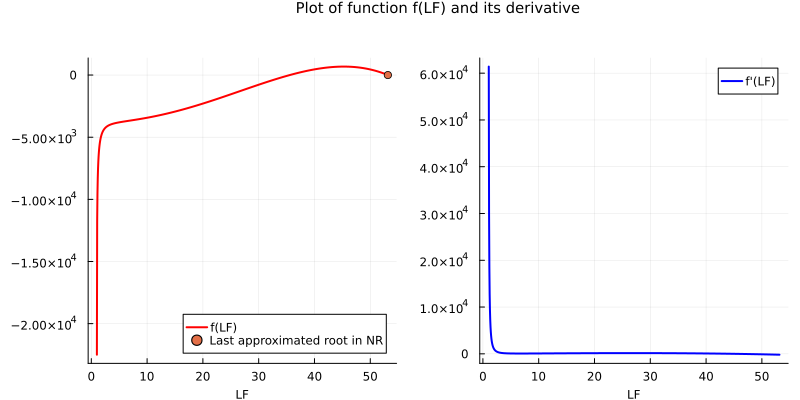

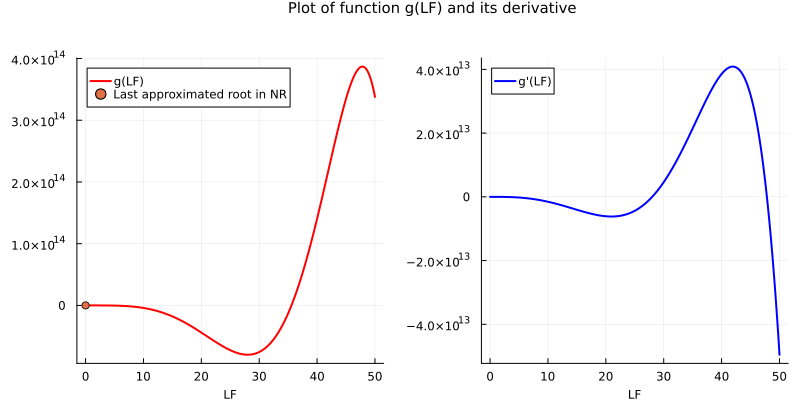

In [8]:
println("The conservative variables: ", u, "\n")

# Verify the admissibility of the conservative variables
q = u[3] - sqrt(u[1]^2 + u[2]^2)
@assert u[1] > 0 && q > 0 "The conservative variables are not in admissible region"

# For the new method of conversion
println("\e[1;4mThe new method of conversion\e[0m")
u_prim_new = con2prim_rc_new(u)
println("The converted primitive variables: ", u_prim_new)

# Lorentz factor after the conversion with the new method of conversion
LF = 1 / sqrt(1 - u_prim_new[2]^2)
println("The corresponding Lorentz factor LF = ", LF)

# For the Ryu's method of conversion
println("\n\e[1;4mThe Ryu's method of conversion\e[0m")
prim1, prim2 = con2prim_rc_Ryu(u)
if prim1 != nothing
    println("The converted primitive variables using f(LF): ", prim1)
end
if prim2 != nothing
    println("The converted primitive variables using g(LF): ", prim2)
end